In [2]:
!pip install tensorflow

In [3]:
!pip install xformers

  Using cached xformers-0.0.20.tar.gz (7.6 MB)
  Preparing metadata (setup.py) ... done
  Using cached pyre_extensions-0.0.29-py3-none-any.whl (12 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl (8.8 kB)
  Using cached mypy_extensions-1.0.0-py3-none-any.whl (4.7 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [258 lines of output]
      running bdist_wheel
      /opt/conda/lib/python3.7/site-packages/torch/utils/cpp_extension.py:476: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
        warnings.warn(msg.format('we could not find ninja.'))
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-37
      creating build/lib.linux-x86_64-cpython-37/xformers
      copying xformers/__init__.py -> build/lib.linux-x86_64-cpython-37/xformers
      copying x

In [4]:
!pip install "transformers[torch]"

In [5]:
!pip install "transformers[tf-cpu]"

In [6]:
!pip install transformers sentencepiece transformers[sentencepiece]

In [7]:
try:
    import sagemaker_datawrangler
except ImportError:
    !pip install --upgrade sagemaker-datawrangler
    import sagemaker_datawrangler


In [8]:
from transformers import pipeline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch

# Task 1: Sentiment Analisys with Huggin Face Transformers

In [9]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [10]:
classifier(["This movie is great", "This is not a great movie"])

[{'label': 'POSITIVE', 'score': 0.9998806715011597},
 {'label': 'NEGATIVE', 'score': 0.9997954964637756}]

In [11]:
classifier(["Esta pelicula no fue para nada buena"])

[{'label': 'NEGATIVE', 'score': 0.9493795037269592}]

In [16]:
df_ = pd.read_csv('AirlineTweets.csv')

In [19]:
display(df_)

                 tweet_id airline_sentiment  airline_sentiment_confidence  \
0      570306133677760513           neutral                        1.0000   
1      570301130888122368          positive                        0.3486   
2      570301083672813571           neutral                        0.6837   
3      570301031407624196          negative                        1.0000   
4      570300817074462722          negative                        1.0000   
...                   ...               ...                           ...   
14635  569587686496825344          positive                        0.3487   
14636  569587371693355008          negative                        1.0000   
14637  569587242672398336           neutral                        1.0000   
14638  569587188687634433          negative                        1.0000   
14639  569587140490866689           neutral                        0.6771   

               negativereason  negativereason_confidence         airline  \

In [21]:
df_.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [22]:
df = df_[['airline_sentiment','text']].copy()

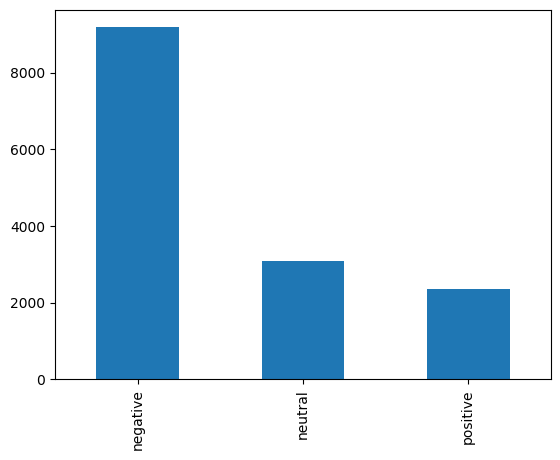

In [31]:
%matplotlib inline
df.airline_sentiment.value_counts().plot(kind='bar')

In [32]:
df = df[df.airline_sentiment!= "neutral"].copy()
df

      airline_sentiment                                               text
1              positive  @VirginAmerica plus you've added commercials t...
3              negative  @VirginAmerica it's really aggressive to blast...
4              negative  @VirginAmerica and it's a really big bad thing...
5              negative  @VirginAmerica seriously would pay $30 a fligh...
6              positive  @VirginAmerica yes, nearly every time I fly VX...
...                 ...                                                ...
14633          negative  @AmericanAir my flight was Cancelled Flightled...
14634          negative         @AmericanAir right on cue with the delays👌
14635          positive  @AmericanAir thank you we got on a different f...
14636          negative  @AmericanAir leaving over 20 minutes Late Flig...
14638          negative  @AmericanAir you have my money, you change my ...

[11541 rows x 2 columns]

In [35]:
class_target_map = {'positive': 1, 'negative':0}
df['target'] = df.airline_sentiment.map(class_target_map)

In [36]:
df

      airline_sentiment                                               text  \
1              positive  @VirginAmerica plus you've added commercials t...   
3              negative  @VirginAmerica it's really aggressive to blast...   
4              negative  @VirginAmerica and it's a really big bad thing...   
5              negative  @VirginAmerica seriously would pay $30 a fligh...   
6              positive  @VirginAmerica yes, nearly every time I fly VX...   
...                 ...                                                ...   
14633          negative  @AmericanAir my flight was Cancelled Flightled...   
14634          negative         @AmericanAir right on cue with the delays👌   
14635          positive  @AmericanAir thank you we got on a different f...   
14636          negative  @AmericanAir leaving over 20 minutes Late Flig...   
14638          negative  @AmericanAir you have my money, you change my ...   

       target  
1           1  
3           0  
4           0  

In [41]:
df_sample = df.sample(frac= 0.05)
len(df_sample)

577

In [42]:
texts = df_sample.text.to_list()

In [43]:
predictions = classifier(texts)

In [45]:
predictions[:10]

[{'label': 'POSITIVE', 'score': 0.9992371797561646},
 {'label': 'NEGATIVE', 'score': 0.9993276596069336},
 {'label': 'POSITIVE', 'score': 0.999567449092865},
 {'label': 'POSITIVE', 'score': 0.5126941204071045},
 {'label': 'NEGATIVE', 'score': 0.9995023012161255},
 {'label': 'POSITIVE', 'score': 0.987414538860321},
 {'label': 'NEGATIVE', 'score': 0.9988572597503662},
 {'label': 'NEGATIVE', 'score': 0.9996138215065002},
 {'label': 'NEGATIVE', 'score': 0.9997256398200989},
 {'label': 'NEGATIVE', 'score': 0.9998118281364441}]

In [48]:
probabilities = [dict_['score'] if dict_['label'].startswith('P') else 1-dict_['score'] for dict_ in predictions]

In [46]:
bool_predictions = [1 if pr['label'].startswith('P') else 0 for pr in predictions]

In [50]:
bool_predictions = np.array(bool_predictions)

In [54]:
print('acc:', np.mean(df_sample.target ==bool_predictions))

acc: 0.8856152512998267


In [55]:
cm = confusion_matrix(df_sample.target, bool_predictions, normalize = 'true')

In [56]:
cm

array([[0.90114943, 0.09885057],
       [0.16197183, 0.83802817]])

In [58]:
def plot_cm(conf_matrix):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(conf_matrix, index = classes, columns =classes)
    ax = sn.heatmap(df_cm, annot =True, fmt ='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

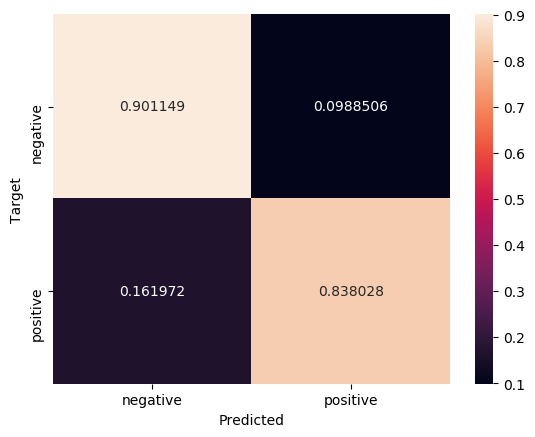

In [59]:
plot_cm(cm)

In [60]:
f1_score(df_sample['target'], bool_predictions)

0.7828947368421053

In [62]:
f1_score(1- df_sample['target'], 1- bool_predictions)

0.9223529411764706

In [63]:
roc_auc_score(df_sample['target'], probabilities)

0.9498947709243969

In [65]:
roc_auc_score(1- df_sample['target'], 1-np.array(probabilities))

0.9498947709243969

# Task 2: Text Generation with Transformers

In [9]:
from transformers import pipeline, set_seed
import textwrap
from pprint import pprint

In [70]:
!cat robert_frost.txt

Two roads diverged in a yellow wood,
And sorry I could not travel both
And be one traveler, long I stood
And looked down one as far as I could
To where it bent in the undergrowth; 

Then took the other, as just as fair,
And having perhaps the better claim
Because it was grassy and wanted wear,
Though as for that the passing there
Had worn them really about the same,

And both that morning equally lay
In leaves no step had trodden black.
Oh, I kept the first for another day! 
Yet knowing how way leads on to way
I doubted if I should ever come back.

I shall be telling this with a sigh
Somewhere ages and ages hence:
Two roads diverged in a wood, and I,
I took the one less traveled by,
And that has made all the difference.

Whose woods these are I think I know.
His house is in the village, though; 
He will not see me stopping here
To watch his woods fill up with snow.

My little horse must think it queer
To stop without a farmhouse near
Between the woods and frozen lake
The darkest evenin

In [71]:
lines = [line.rstrip() for line in open('robert_frost.txt')] 
lines = [line for line in lines if len(line)>0]

In [73]:
generator = pipeline('text-generation')

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [74]:
len(lines)

1436

In [75]:
set_seed(1234)

In [78]:
lines[:5]

['Two roads diverged in a yellow wood,',
 'And sorry I could not travel both',
 'And be one traveler, long I stood',
 'And looked down one as far as I could',
 'To where it bent in the undergrowth;']

In [77]:
generator(lines[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1357: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


[{'generated_text': "Two roads diverged in a yellow wood, while the road in a white puddle was a complete blue on account of the rain coming in. It had been raining outside for some time, so it hadn't taken long for people on both sides of"}]

In [82]:
pprint(generator(lines[0], num_return_sequences=3, max_length =100))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Two roads diverged in a yellow wood, or "black hole" as '
                    'it seems in some of our tales, when the first man, a man '
                    'named "Tommy," was brought aboard the Enterprise, and he '
                    'found himself at the center of an international '
                    'conspiracy to kidnap and destroy the crew as part of the '
                    'plan. One man named "Tom" had a mysterious connection '
                    'with the other. Tom had been one of the very few human '
                    'beings not to have been taken alive (at least so far as'},
 {'generated_text': 'Two roads diverged in a yellow wood, a small town, and, '
                    'with their streets not being as clear as the others, a '
                    'small square of dirt between the town of Yum, Andon, and '
                    'the road of the city of Iztak, were formed into the line '
                    'of the first two roads. From Iztak a 

In [83]:
def wrap(x):
    return textwrap.fill(x, replace_whitespace = False, fix_sentence_endings = True)

In [85]:
out = generator(lines[0],max_length =100)
print(out)
print('\n')
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Two roads diverged in a yellow wood, giving the green signal to the trucks that it's their turn for the rest of us, at which point I stopped and watched our children go down to the river. There was a huge crowd there, so I was sure that the town was full of kids, probably around 100, but my mom made up my mind to have only one kid, so I kept pulling along. The river wasn't nearly quite as good as I'd wanted it to be --"}]


Two roads diverged in a yellow wood, giving the green signal to the
trucks that it's their turn for the rest of us, at which point I
stopped and watched our children go down to the river.  There was a
huge crowd there, so I was sure that the town was full of kids,
probably around 100, but my mom made up my mind to have only one kid,
so I kept pulling along.  The river wasn't nearly quite as good as I'd
wanted it to be --


In [86]:
out1 = generator(lines[1],max_length =100)
out2 = wrap(out[0]['generated_text'])+ '\n' + wrap(out1[0]['generated_text'])
print(out2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Two roads diverged in a yellow wood, giving the green signal to the
trucks that it's their turn for the rest of us, at which point I
stopped and watched our children go down to the river.  There was a
huge crowd there, so I was sure that the town was full of kids,
probably around 100, but my mom made up my mind to have only one kid,
so I kept pulling along.  The river wasn't nearly quite as good as I'd
wanted it to be --
And sorry I could not travel both ways with you.  This is where I'll
be coming from.  In case you're wondering, my daughter is taking care
of a large set of her own.  I should be so happy I can carry you to
somewhere warm.  I've got two bottles of vodka for you, and I should
probably make some for you.  Oh well.  I'll make sure you don't mind
too much, okay?  Goodnight, Mrs.  Potter.

RAW Paste Data


In [94]:
prompt = "Neural Networks with attention have been used with great success" + " in natural language processing."
out_p = generator(prompt, max_length = 300)
print(wrap(out_p[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Neural Networks with attention have been used with great success in
natural language processing.  The use of the network protocol in
artificial language processing has sparked interest in some different
fields, but it is generally accepted that neural networks can be used
with a much broader range of learning mechanisms in order to
efficiently design neural network models.  Most neural networks have
been developed to explore many of the same learning mechanisms, or
even some that can be applied to many of these systems.  A general
overview of neural networks is presented below.

A large section of
this paper focuses on learning algorithms for image formation and
representation.  A more detailed review and some links to more current
papers will be presented in the next sections.  Although there are
more or less limited examples available of image recognition models,
some basic concepts are common within these concepts.

General
principle

If you work with a visual system, then you need 

# Task 3: Fill Mask

In [96]:
mlm = pipeline("fill-mask")

No model was supplied, defaulted to distilroberta-base and revision ec58a5b (https://huggingface.co/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [97]:
mlm ("The cat <mask> over the box")

[{'score': 0.10449183732271194,
  'token': 13855,
  'token_str': ' jumps',
  'sequence': 'The cat jumps over the box'},
 {'score': 0.05758372321724892,
  'token': 33265,
  'token_str': ' crawling',
  'sequence': 'The cat crawling over the box'},
 {'score': 0.04840460047125816,
  'token': 33189,
  'token_str': ' leaping',
  'sequence': 'The cat leaping over the box'},
 {'score': 0.04716670885682106,
  'token': 10907,
  'token_str': ' climbing',
  'sequence': 'The cat climbing over the box'},
 {'score': 0.03080788441002369,
  'token': 32564,
  'token_str': ' leaps',
  'sequence': 'The cat leaps over the box'}]

In [98]:
df_bbc = pd.read_csv('bbc_text_cls.csv')

In [99]:
display(df_bbc)

                                                   text    labels
0     Ad sales boost Time Warner profit\n\nQuarterly...  business
1     Dollar gains on Greenspan speech\n\nThe dollar...  business
2     Yukos unit buyer faces loan claim\n\nThe owner...  business
3     High fuel prices hit BA's profits\n\nBritish A...  business
4     Pernod takeover talk lifts Domecq\n\nShares in...  business
...                                                 ...       ...
2220  BT program to beat dialler scams\n\nBT is intr...      tech
2221  Spam e-mails tempt net shoppers\n\nComputer us...      tech
2222  Be careful how you code\n\nA new European dire...      tech
2223  US cyber security chief resigns\n\nThe man mak...      tech
2224  Losing yourself in online gaming\n\nOnline rol...      tech

[2225 rows x 2 columns]

In [100]:
labels = set(df_bbc['labels'])

In [101]:
labels

{'business', 'entertainment', 'politics', 'sport', 'tech'}

In [102]:
label = "business"

In [103]:
texts = df_bbc[df_bbc['labels'] == label]['text']

In [ ]:
np.random.seed(1234)

In [106]:
i = np.random.choice(len(texts))

In [108]:
doc = texts.iloc[i]

In [110]:
doc

'Bombardier chief to leave company\n\nShares in train and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the board.\n\nPaul Tellier, who was also Bombardier\'s president, left the company amid an ongoing restructuring. Laurent Beaudoin, part of the family that controls the Montreal-based firm, will take on the role of CEO under a newly created management structure. Analysts said the resignations seem to have stemmed from a boardroom dispute. Under Mr Tellier\'s tenure at the company, which began in January 2003, plans to cut the worldwide workforce of 75,000 by almost a third by 2006 were announced. The firm\'s snowmobile division and defence services unit were also sold and Bombardier started the development of a new aircraft seating 110 to 135 passengers.\n\nMr Tellier had indicated he wanted to stay at the world\'s top train maker and third largest manufacturer of civil aircraft until the restructuring was

In [111]:
print(textwrap.fill(doc, replace_whitespace = False, fix_sentence_endings = True))

Bombardier chief to leave company

Shares in train and plane-making
giant Bombardier have fallen to a 10-year low following the departure
of its chief executive and two members of the board.

Paul Tellier,
who was also Bombardier's president, left the company amid an ongoing
restructuring.  Laurent Beaudoin, part of the family that controls the
Montreal-based firm, will take on the role of CEO under a newly
created management structure.  Analysts said the resignations seem to
have stemmed from a boardroom dispute.  Under Mr Tellier's tenure at
the company, which began in January 2003, plans to cut the worldwide
workforce of 75,000 by almost a third by 2006 were announced.  The
firm's snowmobile division and defence services unit were also sold
and Bombardier started the development of a new aircraft seating 110
to 135 passengers.

Mr Tellier had indicated he wanted to stay at the
world's top train maker and third largest manufacturer of civil
aircraft until the restructuring was comple

In [113]:
mlm('Bombardier chief to leave company <mask>')

[{'score': 0.1042889654636383,
  'token': 9313,
  'token_str': ' »',
  'sequence': 'Bombardier chief to leave company »'},
 {'score': 0.05480385571718216,
  'token': 14789,
  'token_str': ' fold',
  'sequence': 'Bombardier chief to leave company fold'},
 {'score': 0.04706911742687225,
  'token': 792,
  'token_str': ' board',
  'sequence': 'Bombardier chief to leave company board'},
 {'score': 0.04189793020486832,
  'token': 4,
  'token_str': '.',
  'sequence': 'Bombardier chief to leave company.'},
 {'score': 0.025414438918232918,
  'token': 10984,
  'token_str': ' payroll',
  'sequence': 'Bombardier chief to leave company payroll'}]

In [118]:
mlm ('Shares in and plane-making'+\
'giant Bombardier have fallen to a 10-year low following the departure' +\
'of its chief <mask> and two members of the board.')

[{'score': 0.9855499863624573,
  'token': 1031,
  'token_str': ' executive',
  'sequence': 'Shares in and plane-makinggiant Bombardier have fallen to a 10-year low following the departureof its chief executive and two members of the board.'},
 {'score': 0.01038985513150692,
  'token': 4585,
  'token_str': ' executives',
  'sequence': 'Shares in and plane-makinggiant Bombardier have fallen to a 10-year low following the departureof its chief executives and two members of the board.'},
 {'score': 0.0011134527157992125,
  'token': 1036,
  'token_str': ' officer',
  'sequence': 'Shares in and plane-makinggiant Bombardier have fallen to a 10-year low following the departureof its chief officer and two members of the board.'},
 {'score': 0.0007766957278363407,
  'token': 7473,
  'token_str': ' economist',
  'sequence': 'Shares in and plane-makinggiant Bombardier have fallen to a 10-year low following the departureof its chief economist and two members of the board.'},
 {'score': 0.0004533157

### Mask excersice

In [119]:
len(texts)

510

In [127]:
texts

0      Ad sales boost Time Warner profit\n\nQuarterly...
1      Dollar gains on Greenspan speech\n\nThe dollar...
2      Yukos unit buyer faces loan claim\n\nThe owner...
3      High fuel prices hit BA's profits\n\nBritish A...
4      Pernod takeover talk lifts Domecq\n\nShares in...
                             ...                        
505    Trial begins of Spain's top banker\n\nThe tria...
506    UK economy ends year with spurt\n\nThe UK econ...
507    HealthSouth ex-boss goes on trial\n\nThe forme...
508    Euro firms miss out on optimism\n\nMore than 9...
509    Lacroix label bought by US firm\n\nLuxury good...
Name: text, Length: 510, dtype: object

In [10]:
from collections import Counter

In [167]:
doc_freq = Counter({})
index_tfidf ={}
doc_size = len(texts)

In [168]:
for txt in texts:
    txt_ = txt.rstrip()
    txt_ = txt_.split()
    doc_freq = doc_freq + Counter(set(txt_))

In [169]:
for i in range(len(texts)):
    txt_ = texts[i].rstrip()
    txt_ = txt_.split()
    doc_size = len(txt_)
    '''
    index_tfidf[i] = sorted([(x, round(y/np.log(doc_size/doc_freq[x]),2)) for x,y in Counter(txt_).items()],\
                             key = lambda t:t[1], reverse = True)
    '''  
    index_tfidf[i] = sorted([(x, round(y/doc_freq[x],2)) for x,y in Counter(txt_).items()],\
                             key = lambda t:t[1], reverse = True)

In [214]:
def mask_doc(doc_index, n_words = 10):
    top_n = list(map(lambda x:x[0], index_tfidf[doc_index][:n_words]))
    dict_replacements = {}
    
    for w in top_n:
        res = mlm(texts.iloc[doc_index].replace(w,'<mask>',1))
        dict_replacements[w] = res[0]['token_str']

    
    new_text = texts.iloc[doc_index]
    for k,v in dict_replacements.items():
        new_text = new_text.replace(k,v)
        
    return texts.iloc[doc_index], new_text, dict_replacements
    

In [215]:
# masking documents
random_index = 1
texto_original, texto_mask, dict_replaces = mask_doc(random_index)

In [216]:
texto_original

'Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\n\nAnd Alan Greenspan highlighted the US government\'s willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan\'s speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. "I think the chairman\'s taking a much more sanguine view on the current account deficit than he\'s taken for some time," said Robert Sinche, head of currency strategy at Bank of America in New York. "He\'s taking a longer-term view, laying out a set of conditions u

In [217]:
dict_replaces

{'stabilise.': ' shrink',
 '$1.2871': ' parity',
 '$1.2974': ' lows',
 "Greenspan's": ' Carney',
 "chairman's": ' chairman',
 'sanguine': ' nuanced',
 "he's": ' has',
 'Sinche,': ' Dudley',
 'view,': ' view',
 'next."': ' beyond'}

# Task 4: NER

In [11]:
import pickle
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.metrics import f1_score, accuracy_score

In [14]:
ner = pipeline("ner", aggregation_strategy ='simple')

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [15]:
with open('ner_train.pkl', 'rb') as f:
    corpus_train = pickle.load(f)

In [16]:
with open('ner_test.pkl', 'rb') as f:
    corpus_test = pickle.load(f)

In [17]:
corpus_test[0]

[('CRICKET', 'O'),
 ('-', 'O'),
 ('LEICESTERSHIRE', 'B-ORG'),
 ('TAKE', 'O'),
 ('OVER', 'O'),
 ('AT', 'O'),
 ('TOP', 'O'),
 ('AFTER', 'O'),
 ('INNINGS', 'O'),
 ('VICTORY', 'O'),
 ('.', 'O')]

In [18]:
inputs = []
targets = []

for sentence_tag_pairs in corpus_test:
    tokens = []
    target = []
    for toke, tag in sentence_tag_pairs:
        tokens.append(toke)
        target.append(tag)
    inputs.append(tokens)
    targets.append(target)

In [19]:

detokenizer = TreebankWordDetokenizer()

In [20]:
# Função que transforma lista de tokens em uma unica string,
# se diferencia de " ".join(str) por ser una detokenización inteligente
# que interpreta donde colocar espacios, virgulas, pontos, hifens etc.

detokenizer.detokenize(inputs[9])

'He was well backed by England hopeful Mark Butcher who made 70 as Surrey closed on 429 for seven, a lead of 234.'

In [21]:
ner(detokenizer.detokenize(inputs[9]))

[{'entity_group': 'LOC',
  'score': 0.99967515,
  'word': 'England',
  'start': 22,
  'end': 29},
 {'entity_group': 'PER',
  'score': 0.99974275,
  'word': 'Mark Butcher',
  'start': 38,
  'end': 50},
 {'entity_group': 'ORG',
  'score': 0.9996264,
  'word': 'Surrey',
  'start': 66,
  'end': 72}]

In [30]:
def compute_prediction(tokens, input_, ner_result):
    predicted_tags =[]
    state = 'O'
    current_idx = 0
    for token in tokens:
        index = input_.find(token)
        
        assert(index>=0)
        current_idx +=index
        tag='O'
        for entity in ner_result:
            if (current_idx >= entity['start'] and current_idx < entity['end']):
                if (state == 'O'):
                    state = 'B'
                else:
                    state = 'I'
                tag = f"{state}-{entity['entity_group']}"
                break
        if (tag == 'O'):
            state = 'O'
        predicted_tags.append(tag)
        input_ = input_[index + len(token):]
        current_idx += len(token)
    assert(len(predicted_tags) == len(tokens))
    return predicted_tags

In [27]:
input_ = detokenizer.detokenize(inputs[9])

In [28]:
ner_result = ner(input_)

In [31]:
ptags = compute_prediction(inputs[9], input_, ner_result)

In [32]:
ptags

['O',
 'O',
 'O',
 'O',
 'O',
 'B-LOC',
 'O',
 'B-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [35]:
accuracy_score(targets[9], ptags)

1.0

In [36]:
for targ, pred in zip(targets[9], ptags):
    print(targ, pred)

O O
O O
O O
O O
O O
B-LOC B-LOC
O O
B-PER B-PER
I-PER I-PER
O O
O O
O O
O O
B-ORG B-ORG
O O
O O
O O
O O
O O
O O
O O
O O
O O
O O
O O


# Task 5: Text Summarization

In [37]:
df_sum =pd.read_csv('bbc_text_cls.csv')

In [38]:
display(df_sum)

                                                   text    labels
0     Ad sales boost Time Warner profit\n\nQuarterly...  business
1     Dollar gains on Greenspan speech\n\nThe dollar...  business
2     Yukos unit buyer faces loan claim\n\nThe owner...  business
3     High fuel prices hit BA's profits\n\nBritish A...  business
4     Pernod takeover talk lifts Domecq\n\nShares in...  business
...                                                 ...       ...
2220  BT program to beat dialler scams\n\nBT is intr...      tech
2221  Spam e-mails tempt net shoppers\n\nComputer us...      tech
2222  Be careful how you code\n\nA new European dire...      tech
2223  US cyber security chief resigns\n\nThe man mak...      tech
2224  Losing yourself in online gaming\n\nOnline rol...      tech

[2225 rows x 2 columns]

In [39]:
df_sum.count()

text      2225
labels    2225
dtype: int64

In [40]:
df_sum.text.iloc[0]

'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sig

In [42]:
doc = df_sum[df_sum.labels == 'business']['text'].sample(random_state =42)

In [46]:
def wrap(x):
    return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings = True)

In [47]:
print(wrap(doc.iloc[0]))

Christmas sales worst since 1981

UK retail sales fell in December,
failing to meet expectations and making it by some counts the worst
Christmas since 1981.

Retail sales dropped by 1% on the month in
December, after a 0.6% rise in November, the Office for National
Statistics (ONS) said.  The ONS revised the annual 2004 rate of growth
down from the 5.9% estimated in November to 3.2%. A number of
retailers have already reported poor figures for December.  Clothing
retailers and non-specialist stores were the worst hit with only
internet retailers showing any significant growth, according to the
ONS.

The last time retailers endured a tougher Christmas was 23 years
previously, when sales plunged 1.7%.

The ONS echoed an earlier
caution from Bank of England governor Mervyn King not to read too much
into the poor December figures.  Some analysts put a positive gloss on
the figures, pointing out that the non-seasonally-adjusted figures
showed a performance comparable with 2003. The Novembe

In [48]:
summarizer = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [50]:
doc.iloc[0].split("\n",1)

['Christmas sales worst since 1981',
 '\nUK retail sales fell in December, failing to meet expectations and making it by some counts the worst Christmas since 1981.\n\nRetail sales dropped by 1% on the month in December, after a 0.6% rise in November, the Office for National Statistics (ONS) said. The ONS revised the annual 2004 rate of growth down from the 5.9% estimated in November to 3.2%. A number of retailers have already reported poor figures for December. Clothing retailers and non-specialist stores were the worst hit with only internet retailers showing any significant growth, according to the ONS.\n\nThe last time retailers endured a tougher Christmas was 23 years previously, when sales plunged 1.7%.\n\nThe ONS echoed an earlier caution from Bank of England governor Mervyn King not to read too much into the poor December figures. Some analysts put a positive gloss on the figures, pointing out that the non-seasonally-adjusted figures showed a performance comparable with 2003. T

In [49]:
doc.iloc[0].split("\n",1)[1]

'\nUK retail sales fell in December, failing to meet expectations and making it by some counts the worst Christmas since 1981.\n\nRetail sales dropped by 1% on the month in December, after a 0.6% rise in November, the Office for National Statistics (ONS) said. The ONS revised the annual 2004 rate of growth down from the 5.9% estimated in November to 3.2%. A number of retailers have already reported poor figures for December. Clothing retailers and non-specialist stores were the worst hit with only internet retailers showing any significant growth, according to the ONS.\n\nThe last time retailers endured a tougher Christmas was 23 years previously, when sales plunged 1.7%.\n\nThe ONS echoed an earlier caution from Bank of England governor Mervyn King not to read too much into the poor December figures. Some analysts put a positive gloss on the figures, pointing out that the non-seasonally-adjusted figures showed a performance comparable with 2003. The November-December jump last year wa

In [51]:
summarizer(doc.iloc[0].split("\n",1)[1])

[{'summary_text': ' Retail sales dropped by 1% on the month in December, after a 0.6% rise in November . Clothing retailers and non-specialist stores were the worst hit with only internet retailers showing any significant growth . The last time retailers endured a tougher Christmas was 23 years ago, when sales plunged 1.7% .'}]

In [52]:
def print_summary(doc_):
    result = summarizer(doc_.iloc[0].split('\n',1)[1])
    print(wrap(result[0]['summary_text']))

In [53]:
print_summary(doc)

 Retail sales dropped by 1% on the month in December, after a 0.6%
rise in November . Clothing retailers and non-specialist stores were
the worst hit with only internet retailers showing any significant
growth . The last time retailers endured a tougher Christmas was 23
years ago, when sales plunged 1.7% .


In [58]:
summarizer(doc.iloc[0].split("\n",1)[0])

Your max_length is set to 142, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


[{'summary_text': ' Christmas sales worst since 1981 with Christmas sales worse since 1981 . Christmas sales sales worst year-on-year since 1981, with Christmas Day sales worse than 1981 . Sales slump for the first time in more than 30 years, with sales down by more than a quarter of all sales down .'}]

In [63]:
doc_= df_sum[df_sum.labels == 'business']['text']

In [65]:
i = np.random.choice(len(doc_))

In [69]:
print(wrap(summarizer(doc_.iloc[i].split("\n", 1)[1])[0]['summary_text']))

 BMW sold nearly 95,000 cars in Asia last year, up 2.6% on 2003 .
German carmaker aiming to boost annual sales in Asia to 150,000 by
2008 . China remains main area of concern for BMW after sales there
fell 16% last year . BMW is launching a revamped version of its
3-Series saloon class next month .


In [68]:
print(wrap(doc_.iloc[i]))

BMW drives record sales in Asia

BMW has forecast sales growth of at
least 10% in Asia this year after registering record sales there in
2004.

The luxury carmaker saw strong sales of its three marques -
BMW, Mini and Rolls-Royce - in Asia last year after the launch of
three new models.  The company, which is vying with Mercedes-Benz for
the title of leading premium carmaker, is confident about its
prospects for the region in 2005. It is launching a revamped version
of its 3-Series saloon class next month.

BMW sold nearly 95,000 cars
in Asia last year, up 2.6% on 2003.

BMW-brand sales rose 2.3% to
80,600 while sales of Mini models rose 3.6% to 14,800. There was also
a significant increase in sales of Rolls-Royces on the continent.  BMW
sold more than 100 of the iconic models compared with just ten the
previous year.  The German carmaker is aiming to boost annual sales in
Asia to 150,000 by 2008. "Here in Asia, we consider a double-digit
increase in retail on the order of 10 to 15% to

# Task 5: Machine Translation

In [70]:
!unzip -nq spa-eng.zip

In [71]:
!ls

1.1GptContext.ipynb   AirlineTweets.csv		 ner_test.pkl
1.2.FineTuning.ipynb  Untitled1.ipynb		 ner_train.pkl
1.3.ChatGPT.ipynb     bbc_text_cls.csv		 robert_frost.txt
1.GPT.ipynb	      begincorner.ipynb		 spa-eng
2.Dall-e.ipynb	      cardio_alco.csv		 spa-eng.zip
3.GPTClone.ipynb      cardio_base.csv		 treino.json
4.TestaChat.ipynb     covid_data.csv
5.GPTClone2.ipynb     machine_learning_examples


In [13]:
!ls spa-eng/

_about.txt  spa.txt


In [14]:
!head spa-eng/spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!


In [15]:
eng2spa = {}
for line in open('spa-eng/spa.txt'):
    line = line.rstrip()
    eng, spa = line.split("\t")
    if (eng not in eng2spa):
        eng2spa[eng] =[]
    eng2spa[eng].append(spa)

In [16]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import RegexpTokenizer

In [17]:
tokenizer = RegexpTokenizer(r'\w+')

In [18]:
tokens = tokenizer.tokenize("Qué me cuentas?".lower())

In [19]:
sentence_bleu([tokens], tokens)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1.2213386697554703e-77

In [12]:
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es")

/opt/conda/lib/python3.7/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [20]:
translator("I like eggs and ham")

[{'translation_text': 'Me gustan los huevos y el jamón.'}]

In [21]:
eng_phrases = list(eng2spa.keys())

In [22]:
len(eng_phrases)

102904

In [25]:
eng_phrases_subset =  eng_phrases[20000:20100]

In [26]:
translations =  translator(eng_phrases_subset)

In [28]:
scores = []
for eng, pred in zip (eng_phrases_subset, translations):
    matches = eng2spa[eng]
    spa_pred = tokenizer.tokenize(pred['translation_text'].lower())
    
    score = sentence_bleu(matches, spa_pred)
    scores.append(score)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [29]:
scores

[0,
 0,
 0,
 0,
 0,
 2.725503796035106e-233,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.826959830028561e-233,
 0,
 0,
 0,
 6.065720248837714e-233,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5.576354408956027e-233,
 1.4957881974825052e-233,
 2.518691618724825e-233,
 2.518691618724825e-233,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2.2314537754447196e-233,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4.152620446125756e-233,
 0,
 0,
 1.8167085284303287e-233,
 2.975482570578e-233,
 1.8167085284303287e-233,
 0,
 1.8375610538439091e-233,
 0,
 0,
 0,
 0,
 4.905741404709443e-233,
 0,
 0,
 0,
 0,
 0]

In [31]:
import matplotlib.pyplot as plt

(array([86.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  2.,  2.,  0.,  0.,  1.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.00000000e+000, 1.21314405e-234, 2.42628810e-234, 3.63943215e-234,
        4.85257620e-234, 6.06572025e-234, 7.27886430e-234, 8.49200835e-234,
        9.70515240e-234, 1.09182964e-233, 1.21314405e-233, 1.33445845e-233,
        1.45577286e-233, 1.57708726e-233, 1.69840167e-233, 1.81971607e-233,
        1.94103048e-233, 2.06234488e-233, 2.18365929e-233, 2.30497369e-233,
        2.42628810e-233, 2.54760250e-233, 2.66891691e-233, 2.79023131e-233,
        2.91154572e-233, 3.03286012e-233, 3.15417453e-233, 3.27548893e-233,
        3.39680334e-233, 3.51811774e-233, 3.63943215e-233, 3.76074655e-233,
        3.88206096e-233, 4.00337536e-233, 4.12468977e-233, 4.24600417e-233,
        4.36731858e-233, 4.48863

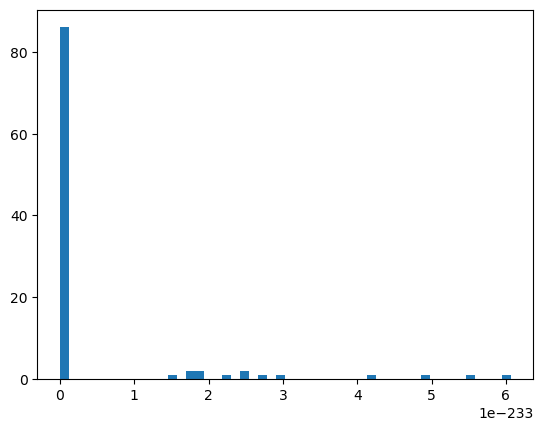

In [33]:
%matplotlib inline
plt.hist(scores, bins = 50)

In [34]:
np.mean(scores)

4.2463986026352043e-234

# Task 6: Machine Translation

In [36]:
qa = pipeline ("question-answering")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [45]:
context = " Today I went to the store to purchase a carton of milk."
question = "finally, what was buyed"

In [46]:
qa(context = context, question=question)

{'score': 0.544958770275116,
 'start': 39,
 'end': 55,
 'answer': 'a carton of milk'}

In [51]:
context = "Out of all colors, I like blue the best"
question = "What is your favourite color?"

In [52]:
qa(context = context, question=question)

{'score': 0.9929803013801575, 'start': 26, 'end': 30, 'answer': 'blue'}

# Task 7: Zero-Shot Classification

In [53]:
classifier = pipeline("zero-shot-classification")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [54]:
classifier("This is a great movie", candidate_labels=["positive", "negative"])

{'sequence': 'This is a great movie',
 'labels': ['positive', 'negative'],
 'scores': [0.9969461560249329, 0.003053841879591346]}

In [55]:
df_bbc = pd.read_csv('bbc_text_cls.csv')

In [56]:
len(df_bbc)

2225

In [57]:
df_bbc.sample(frac=1).head()

                                                   text         labels
1319  O'Sullivan commits to Dublin race\n\nSonia O'S...          sport
892   French honour for director Parker\n\nBritish f...  entertainment
1266  Howard pitches for UK ethnic vote\n\nMichael H...       politics
283   Iraqi voters turn to economic issues\n\nBeyond...       business
1834  UK net users leading TV downloads\n\nBritish T...           tech

In [58]:
labels = list(set(df_bbc.labels))

In [59]:
labels

['tech', 'politics', 'entertainment', 'sport', 'business']

In [61]:
df_bbc.iloc[1024]['text']

'UK troops on Ivory Coast standby\n\nDowning Street has confirmed British troops are on standby in case they need to help evacuate several hundred UK citizens from Ivory Coast.\n\nThe news came as it emerged France had begun evacuating its hostages after days of anti-French demonstrations. Trouble flared after nine French peacekeepers were killed and President Jacques Chirac ordered the destruction of the Ivory Coast\'s air force. A company of 100-120 UK troops is understood to have been put on standby. They are ready to fly out and secure the route from the embassy to the airport if called upon. Prime Minister Tony Blair\'s official spokesman said: "There are British nationals in Ivory Coast and as you can imagine we are making the usual contingency plans in case the situation deteriorates further, but that\'s all I can say at this stage."\n\nHe added the situation would be monitored carefully in case evacuation became necessary. France has played a lead role in international peacekee

In [60]:
print(textwrap.fill(df_bbc.iloc[1024]['text']))

UK troops on Ivory Coast standby  Downing Street has confirmed British
troops are on standby in case they need to help evacuate several
hundred UK citizens from Ivory Coast.  The news came as it emerged
France had begun evacuating its hostages after days of anti-French
demonstrations. Trouble flared after nine French peacekeepers were
killed and President Jacques Chirac ordered the destruction of the
Ivory Coast's air force. A company of 100-120 UK troops is understood
to have been put on standby. They are ready to fly out and secure the
route from the embassy to the airport if called upon. Prime Minister
Tony Blair's official spokesman said: "There are British nationals in
Ivory Coast and as you can imagine we are making the usual contingency
plans in case the situation deteriorates further, but that's all I can
say at this stage."  He added the situation would be monitored
carefully in case evacuation became necessary. France has played a
lead role in international peacekeeping in Iv

In [62]:
df_bbc.iloc[1024]['labels']

'politics'

In [63]:
classifier(df_bbc.iloc[1024]['text'], candidate_labels=labels)

{'sequence': 'UK troops on Ivory Coast standby\n\nDowning Street has confirmed British troops are on standby in case they need to help evacuate several hundred UK citizens from Ivory Coast.\n\nThe news came as it emerged France had begun evacuating its hostages after days of anti-French demonstrations. Trouble flared after nine French peacekeepers were killed and President Jacques Chirac ordered the destruction of the Ivory Coast\'s air force. A company of 100-120 UK troops is understood to have been put on standby. They are ready to fly out and secure the route from the embassy to the airport if called upon. Prime Minister Tony Blair\'s official spokesman said: "There are British nationals in Ivory Coast and as you can imagine we are making the usual contingency plans in case the situation deteriorates further, but that\'s all I can say at this stage."\n\nHe added the situation would be monitored carefully in case evacuation became necessary. France has played a lead role in internati

In [76]:
new_df_bbc = df_bbc.sample(frac=0.001)

In [77]:
len(new_df_bbc)

2

In [78]:
text_bbc_ds = new_df_bbc['text'].tolist()
labels_bbc_ds = new_df_bbc['labels'].tolist()

In [79]:
zero_shot_preds = classifier(text_bbc_ds, candidate_labels=labels)

In [80]:
zero_shot_preds = [clf['labels'][0] for clf in zero_shot_preds]

In [81]:
new_df_bbc['predictions'] = zero_shot_preds

In [82]:
print("acc:", np.mean(new_df_bbc['predictions']==new_df_bbc['labels']))

acc: 0.5
